
# The files that you need to deal with are:
1.   VPTD_Dataset.csv  :: contains the ground truth for personality traits and sales  estimation
2.   smiles.csv :: contains the smiles detected in each video from the dataset.
3.   head_movements.json :: contains the info about the head movments (roll, pitch, yaw) for each frame




## Task 1: (2 marks)
Read the files and check their structure for further processing






In [1]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

vptd_df = pd.read_csv("VPTD_Dataset.csv")
print("VPTD_Dataset:")
print(vptd_df.head())

smiles_df = pd.read_csv("smiles.csv")
print("\nsmiles:")
print(smiles_df.head())
# Change names for merge and calc ratio of frames with smiles
for i in range(0, len(smiles_df.index)):
    smiles_df.at[i, "names"] = str(smiles_df.at[i, "names"]).replace(".mp4", "")
    smiles_df.at[i, "total_frames"] = (
        smiles_df.at[i, "smiles"] / smiles_df.at[i, "total_frames"]
    )
smiles_df = smiles_df.rename(columns={"total_frames": "ratio_smiles"})
print(smiles_df.head())

with open("head_movements.json", "r") as f:
    head_movements_data = json.load(f)
head_movements_df = pd.DataFrame(head_movements_data).T
print("\nhead_movements:")
print(head_movements_df.head())

# Calc stat features for head move and create new DataFrame
stat_data = []
features = ["Roll", "Pitch", "Yaw"]
stat_features = {}
for i, row in head_movements_df.iterrows():
    stat_features = {"Id_name": i}
    for feature in features:
        stat_features[f"{feature}_mean"] = np.mean(row[feature])
        stat_features[f"{feature}_std"] = np.std(row[feature])
        stat_features[f"{feature}_min"] = np.min(row[feature])
        stat_features[f"{feature}_max"] = np.max(row[feature])
    stat_data.append(stat_features)

stat_df = pd.DataFrame(stat_data)
print("\stat_df:")
print(stat_df.head())

VPTD_Dataset:
       Id_name  Extraversion  Agreeableness  Conscientiousness  Neuroticism  \
0  wzewmMk_Nzv          0.56           0.55               0.67         0.62   
1  MKdgEMd_con          0.72           0.85               0.77         0.27   
2  pjlESEZ_rgA          0.56           0.68               0.83         0.45   
3  HmakBQy_Zuo          0.64           0.52               0.80         0.32   
4  PMoGeaZ_lek          0.65           0.71               0.67         0.48   

   Openness  SE  OE  
0      0.59   2   6  
1      0.70   4   8  
2      0.67   3   7  
3      0.65   4   9  
4      0.68   2   7  

smiles:
             names  smiles  total_frames
0  byeCjvS_oUH.mp4       0          2614
1  jsjWCIa_tli.mp4       4          6290
2  QYJOylc_eWg.mp4      54          2936
3  gwdnjsF_tFL.mp4       0          2415
4  exSnMmq_NJW.mp4      31          3455
         names  smiles  ratio_smiles
0  byeCjvS_oUH       0      0.000000
1  jsjWCIa_tli       4      0.000636
2  QYJOylc_eW

## Task 2: (3 marks)
Show the correlation between smiles and Extraversion.


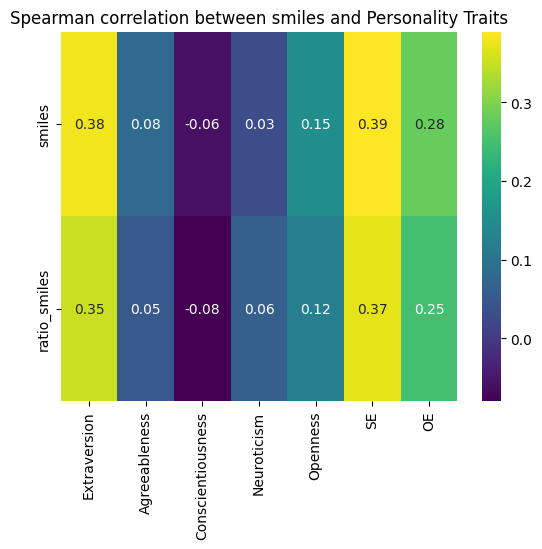

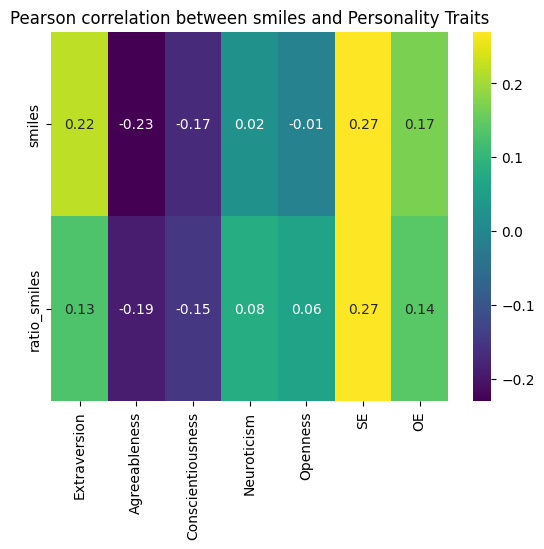

In [2]:
merged_df = pd.merge(smiles_df, vptd_df, left_on="names", right_on="Id_name")
merged_df.drop("names", axis=1, inplace=True)
merged_df.drop("Id_name", axis=1, inplace=True)

merged_df_corr_spearman = merged_df.corr(method="spearman").round(decimals=2)
merged_df_corr_pearson = merged_df.corr(method="pearson").round(decimals=2)

features = ["smiles", "ratio_smiles"]
traits = ["Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness", "SE", "OE"]

sns.heatmap(merged_df_corr_spearman.loc[features, traits], annot=True, cmap="viridis")
plt.title("Spearman correlation between smiles and Personality Traits")
plt.show()

sns.heatmap(merged_df_corr_pearson.loc[features, traits], annot=True, cmap="viridis")
plt.title("Pearson correlation between smiles and Personality Traits")
plt.show()

## Task 3: (5 marks)
Show the correlation between head movements and personality traits.


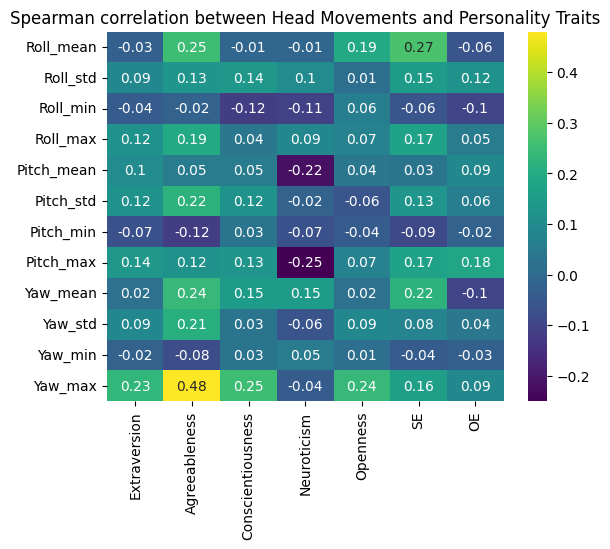

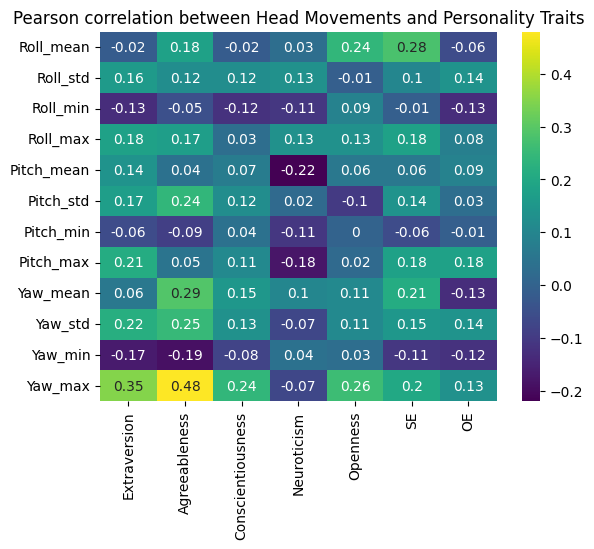

In [3]:
merged_df = pd.merge(stat_df, vptd_df, on="Id_name")
merged_df.drop("Id_name", axis=1, inplace=True)

merged_df_corr_spearman = merged_df.corr(method="spearman").round(decimals=2)
merged_df_corr_pearson = merged_df.corr(method="pearson").round(decimals=2)

features = ["Roll_mean", "Roll_std", "Roll_min", "Roll_max", "Pitch_mean", "Pitch_std", "Pitch_min", "Pitch_max", "Yaw_mean", "Yaw_std", "Yaw_min", "Yaw_max"]
traits = ["Extraversion", "Agreeableness", "Conscientiousness", "Neuroticism", "Openness", "SE", "OE"]

sns.heatmap(merged_df_corr_spearman.loc[features, traits], annot=True, cmap="viridis")
plt.title("Spearman correlation between Head Movements and Personality Traits")
plt.show()

sns.heatmap(merged_df_corr_pearson.loc[features, traits], annot=True, cmap="viridis")
plt.title("Pearson correlation between Head Movements and Personality Traits")
plt.show()

## Task 4: (4 marks)
Prove the correlation you found between non-verbal cues (smiles and head movements) with personality traits, by training some models to predict the correlated traits depending on the extracted features.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

merged_df = pd.merge(smiles_df, vptd_df, left_on="names", right_on="Id_name")
merged_df.drop("names", axis=1, inplace=True)
dataset_df = pd.merge(merged_df, stat_df, on="Id_name")
dataset_df.drop("Id_name", axis=1, inplace=True)

extracted_features = {
    "Extraversion": ["smiles", "ratio_smiles", "Yaw_max"],
    "Agreeableness": ["Roll_mean", "Roll_max", "Pitch_std", "Yaw_mean", "Yaw_std", "Yaw_max"],
    "Conscientiousness": ["Yaw_max", "Yaw_mean", "Pitch_max", "Roll_std", "Roll_min", "Pitch_std"],
    "Neuroticism": ["Pitch_mean", "Pitch_max", "Yaw_mean"],
    "Openness": ["Yaw_max", "Roll_mean", "smiles"],
    "SE": ["smiles", "ratio_smiles", "Roll_mean", "Yaw_mean", "Roll_max", "Pitch_max"],
    "OE": ["smiles", "ratio_smiles", "Pitch_max"]
}

models = {
    "Random Forest": RandomForestRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "MLP": MLPRegressor(max_iter=500),
}

results = {}
for trait, features in extracted_features.items():
    X = dataset_df[features]
    y = dataset_df[trait]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        results[name] = {"MSE": mse, "MAE": mae}
    results_df = pd.DataFrame(results).T
    print(f"\nModel Comparison for {trait}:")
    print(results_df)


Model Comparison for Extraversion:
                                MSE       MAE
Random Forest              0.021757  0.122483
GradientBoostingRegressor  0.022759  0.126218
XGBoost                    0.027059  0.133831
MLP                        0.024582  0.117064

Model Comparison for Agreeableness:
                                MSE       MAE
Random Forest              0.018243  0.100738
GradientBoostingRegressor  0.021522  0.107316
XGBoost                    0.025282  0.138042
MLP                        0.177631  0.353853

Model Comparison for Conscientiousness:
                                MSE       MAE
Random Forest              0.032930  0.148921
GradientBoostingRegressor  0.051533  0.186901
XGBoost                    0.045343  0.194142
MLP                        0.332731  0.380721

Model Comparison for Neuroticism:
                                MSE       MAE
Random Forest              0.020990  0.124433
GradientBoostingRegressor  0.021136  0.129593
XGBoost                

/home/ilya/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



Model Comparison for SE:
                                MSE       MAE
Random Forest              1.073142  0.920833
GradientBoostingRegressor  1.856270  1.213144
XGBoost                    2.749568  1.434781
MLP                        3.680536  1.620864

Model Comparison for OE:
                                  MSE       MAE
Random Forest                3.172058  1.550833
GradientBoostingRegressor    3.023109  1.516386
XGBoost                      2.832347  1.462847
MLP                        167.422658  6.089004


#List of Papers:


1.   http://dx.doi.org/10.23919/FRUCT58615.2023.10143053
2.   http://dx.doi.org/10.3390/data8070113
3.   http://dx.doi.org/10.23919/FRUCT61870.2024.10516365

